## Convert the census tract data to a geopandas dataframe

We've downloaded the 2010 census tract shapefiles data. Here is a link to what the columns mean: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html#list-tab-790442341

In [1]:
import zipfile
import os, shutil
from shapely import MultiPolygon, Polygon, wkt, intersection
import geopandas as gpd
import matplotlib.pyplot as plt
!jupyter nbconvert --to script census_data_chicago.ipynb


[NbConvertApp] Converting notebook census_data_chicago.ipynb to script
[NbConvertApp] Writing 20287 bytes to census_data_chicago.py


In [20]:
def load_tiger_shapefile(zip_path):
    # Unzip the TIGER/Line Shapefile if it's in a .zip format
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_dir = zip_path.rstrip('.zip')
        zip_ref.extractall(extract_dir)

    # Find the main shapefile (the one with .shp extension)
    shp_file = next((f for f in os.listdir(extract_dir) if f.endswith('.shp')), None)
    if not shp_file:
        raise FileNotFoundError("No .shp file found in the extracted contents")

    # Load shapefile into a GeoDataFrame
    gdf = gpd.read_file(os.path.join(extract_dir, shp_file))
    
    # Clean up extracted files if desired
    shutil.rmtree(extract_dir)

    return gdf

zip_path = '../project_data/chc/tl_2010_17_tract10.zip' # path to the TIGER/Line Shapefile ZIP file
gdf = load_tiger_shapefile(zip_path)
gdf = gdf.loc[gdf['COUNTYFP10'] == '031'] # 031 is the 2010 FIPS code for Cook County
gdf = gdf[['TRACTCE10', 'geometry']] # only keep the relevant columns

In [21]:
gdf

,TRACTCE10,geometry
1310,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
1311,840200,"POLYGON ((-87.64633 41.84009, -87.64632 41.839..."
1312,841100,"POLYGON ((-87.62935 41.8528, -87.62934 41.8525..."
1313,841200,"POLYGON ((-87.68814 41.85569, -87.68816 41.856..."
1314,838200,"POLYGON ((-87.66782 41.87418, -87.66768 41.874..."
...,...,...
2705,823604,"POLYGON ((-87.78982 41.64633, -87.79053 41.646..."
2706,825501,"POLYGON ((-87.702 41.5717, -87.70213 41.5717, ..."
2707,825302,"POLYGON ((-87.75998 41.58827, -87.7598 41.5882..."
2708,823602,"POLYGON ((-87.77216 41.6466, -87.77227 41.6466..."


## Set up the census data

Following the instructions on https://pypi.org/project/census/, we obtained a Census API key.

In [22]:
#!pip install census
#!pip install us

In [23]:
from census import Census
from us import states
import pandas as pd

In [ ]:
c = Census(PUT YOUR API KEY HERE)

In [25]:
def get_census_data(census_fields={'NAME': 'name'}):
    tract_data = c.acs5.get(tuple(census_fields.keys()), {'for': 'tract:*', 'in': 'state:17 county:031'})
    
    # convert the tract data to a pandas DataFrame
    df = pd.DataFrame(tract_data)

    # rename the columns of df for readability
    df.rename(columns=census_fields, inplace=True)

    return df


The ACS codes can be found here: https://api.census.gov/data/2010/acs/acs5/variables.html

In [ ]:
census_fields = {'NAME': 'name',
                'B01003_001E': 'total_population',
                'B19013_001E': 'median_household_income',

                'B02001_002E': 'white_alone',
                'B02001_003E': 'black_alone',
                'B02001_004E': 'indigenous_alone',
                'B02001_005E': 'asian_alone',
                'B02001_006E': 'pacific_islander_alone',
                'B02001_007E': 'other_alone',
                'B02001_008E': 'multiracial',
                 'B08141_031E': 'work_from_home',
                 'B08301_001E': 'automobile_to_work',
                 'B08301_010E': 'public_transit_to_work',
                 'B08301_016E': 'taxi_to_work',
                 'B08301_017E': 'motorcycle_to_work',
                 'B08301_018E': 'bike_to_work',
                 'B08301_019E': 'walk_to_work',
                 'B08301_020E': 'other_to_work',
                 'B01002_001E': 'median_age',
                 'B17001_002E': 'below_poverty_line',
                 'B17001_001E': 'poverty_total',
                 'B15001_001E': 'total_population_18_up'
    
                 
                 
                 
                 
                }
census_fields = census_fields #| sex_by_age_fields
census_data = get_census_data(census_fields)

Here's a utility function that will be useful when we need to add a bunch of columns.

In [27]:
def get_census_data_then_sum(acs_codes=[], total_column_name='total'):
    df = get_census_data({'NAME': 'name'} | {x:x for x in acs_codes})
    
    # Create the total column. Note that the last three columns are state, county, and tract.
    df[total_column_name] = df.iloc[:, 1:-3].sum(axis=1)

    # Keep only the necessary columns
    return df[['name', total_column_name, 'tract']]

### Employment

In [28]:
employment_data = get_census_data({'NAME': 'name'})


acs_prefix_employment = 'B23001'

total_start = 10
total_end = 66
labor_start = 11
labor_end = 67
unempl_start = 15
unempl_end = 71
nolabor_start = 16
nolabor_end = 72
male_female_offset = 86

acs_total_male_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(total_start, 
                                                                                        total_end + 1,
                                                                                        7)] #Male 20-64 
acs_total_female_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(total_start + male_female_offset,
                                                                                          total_end + male_female_offset + 1,
                                                                                          7)] #Female 20-64

acs_in_labor_force_male_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(labor_start,
                                                                                                 labor_end + 1,
                                                                                                 7)] #Male 20-64 
acs_in_labor_force_female_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(labor_start + male_female_offset,
                                                                                          labor_end + male_female_offset + 1,
                                                                                                   7)] #Female 20-64

acs_unemployed_male_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(unempl_start,
                                                                                                 unempl_end + 1,
                                                                                                 7)] #Male 20-64 
acs_unemployed_female_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(unempl_start + male_female_offset,
                                                                                          unempl_end + male_female_offset + 1,
                                                                                                   7)] #Female 20-64

acs_not_in_labor_force_male_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(nolabor_start,
                                                                                                 nolabor_end + 1,
                                                                                                 7)] #Male 20-64 
acs_not_in_labor_force_female_20_64 = ['{}_{}E'.format(acs_prefix_employment,f'{i:03}') for i in range(nolabor_start + male_female_offset,
                                                                                          nolabor_end + male_female_offset + 1,
                                                                                                   7)] #Female 20-64

total_20_64_data = get_census_data_then_sum(acs_total_male_20_64 + acs_total_female_20_64,
                                            total_column_name='total_pop_20_64_for_employment')
in_labor_force_20_64_data = get_census_data_then_sum(acs_in_labor_force_male_20_64 + acs_in_labor_force_female_20_64,
                                            total_column_name='in_labor_force_20_64')
not_in_labor_force_20_64_data = get_census_data_then_sum(acs_not_in_labor_force_male_20_64 + acs_not_in_labor_force_female_20_64,
                                            total_column_name='not_in_labor_force_20_64')
unemployed_20_64_data = get_census_data_then_sum(acs_unemployed_male_20_64 + acs_unemployed_female_20_64,
                                            total_column_name='unemployed_20_64')

for dataset in [total_20_64_data, in_labor_force_20_64_data, not_in_labor_force_20_64_data, unemployed_20_64_data]:
    employment_data = employment_data.merge(dataset, on=['name', 'tract'])

We now merge employment data into `census_data`.

In [29]:
census_data = census_data.merge(employment_data, on=['name', 'state', 'county', 'tract'])

In [30]:
census_data

,name,total_population,median_household_income,white_alone,black_alone,indigenous_alone,asian_alone,pacific_islander_alone,other_alone,multiracial,...,below_poverty_line,poverty_total,total_population_18_up,state,county,tract,total_pop_20_64_for_employment,in_labor_force_20_64,not_in_labor_force_20_64,unemployed_20_64
0,Census Tract 101; Cook County; Illinois,4284.0,68196.0,1915.0,1376.0,0.0,94.0,0.0,278.0,621.0,...,815.0,4183.0,3877.0,17,031,010100,3113.0,2641.0,472.0,223.0
1,Census Tract 102.01; Cook County; Illinois,8210.0,61071.0,2087.0,3009.0,41.0,298.0,0.0,838.0,1937.0,...,2756.0,8200.0,5815.0,17,031,010201,4826.0,3538.0,1288.0,138.0
2,Census Tract 102.02; Cook County; Illinois,2865.0,58698.0,892.0,945.0,86.0,312.0,0.0,353.0,277.0,...,609.0,2564.0,2374.0,17,031,010202,1918.0,1388.0,530.0,133.0
3,Census Tract 103; Cook County; Illinois,6237.0,68336.0,3343.0,1473.0,76.0,338.0,0.0,704.0,303.0,...,344.0,5329.0,5701.0,17,031,010300,4100.0,3300.0,800.0,104.0
4,Census Tract 104; Cook County; Illinois,4473.0,48630.0,3578.0,354.0,0.0,213.0,0.0,71.0,257.0,...,568.0,3056.0,4358.0,17,031,010400,2989.0,2130.0,859.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,Census Tract 8446; Cook County; Illinois,2275.0,54565.0,106.0,2050.0,0.0,0.0,24.0,15.0,80.0,...,593.0,2093.0,1967.0,17,031,844600,1693.0,1148.0,545.0,343.0
1328,Census Tract 8447; Cook County; Illinois,1753.0,51298.0,100.0,1346.0,0.0,0.0,0.0,156.0,151.0,...,449.0,1753.0,1462.0,17,031,844700,1309.0,850.0,459.0,133.0
1329,Census Tract 9800; Cook County; Illinois,0.0,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,17,031,980000,0.0,0.0,0.0,0.0
1330,Census Tract 9801; Cook County; Illinois,0.0,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,17,031,980100,0.0,0.0,0.0,0.0


### Educational attainment

In [31]:
educational_attainment_data = get_census_data({'NAME': 'name'})



educational_attainment_lt_9th_data = get_census_data_then_sum(['B15001_004E', # male 18-24
                                                               'B15001_012E', # male 25-34
                                                               'B15001_020E', # male 35-44
                                                               'B15001_028E', # male 45-64
                                                               'B15001_036E', # male >=65
                                                               'B15001_045E', # female 18-24
                                                               'B15001_053E', # female 25-34
                                                               'B15001_061E', # female 35-44
                                                               'B15001_069E', # female 45-64
                                                               'B15001_077E' # female >=65
                                                               ],
                                                               total_column_name='<9th')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_lt_9th_data, 
                                                               on=['name', 'tract'])

# 9th to 12th grade, no diploma
educational_attainment_no_diploma = get_census_data_then_sum(['B15001_005E', # male 18-24
                                                               'B15001_013E', # male 25-34
                                                               'B15001_021E', # male 35-44
                                                               'B15001_029E', # male 45-64
                                                               'B15001_037E', # male >=65
                                                               'B15001_046E', # female 18-24
                                                               'B15001_054E', # female 25-34
                                                               'B15001_062E', # female 35-44
                                                               'B15001_070E', # female 45-64
                                                               'B15001_078E' # female >=65
                                                               ],
                                                               total_column_name='no_diploma')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_no_diploma, 
                                                               on=['name', 'tract'])

# High school graduate, GED, or alternative
educational_attainment_high_school = get_census_data_then_sum(['B15001_006E', # male 18-24
                                                               'B15001_014E', # male 25-34
                                                               'B15001_022E', # male 35-44
                                                               'B15001_030E', # male 45-64
                                                               'B15001_038E', # male >=65
                                                               'B15001_047E', # female 18-24
                                                               'B15001_055E', # female 25-34
                                                               'B15001_063E', # female 35-44
                                                               'B15001_071E', # female 45-64
                                                               'B15001_079E' # female >=65
                                                               ],
                                                               total_column_name='high_school')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_high_school,
                                                               on=['name', 'tract'])

# Some college, no degree
educational_attainment_some_college = get_census_data_then_sum(['B15001_007E', # male 18-24
                                                               'B15001_015E', # male 25-34
                                                               'B15001_023E', # male 35-44
                                                               'B15001_031E', # male 45-64
                                                               'B15001_039E', # male >=65
                                                               'B15001_048E', # female 18-24
                                                               'B15001_056E', # female 25-34
                                                               'B15001_064E', # female 35-44
                                                               'B15001_072E', # female 45-64
                                                               'B15001_080E' # female >=65
                                                               ],
                                                               total_column_name='some_college')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_some_college,
                                                               on=['name', 'tract'])

# Associate's degree
educational_attainment_associates = get_census_data_then_sum(['B15001_008E', # male 18-24
                                                               'B15001_016E', # male 25-34
                                                               'B15001_024E', # male 35-44
                                                               'B15001_032E', # male 45-64
                                                               'B15001_040E', # male >=65
                                                               'B15001_049E', # female 18-24
                                                               'B15001_057E', # female 25-34
                                                               'B15001_065E', # female 35-44
                                                               'B15001_073E', # female 45-64
                                                               'B15001_081E' # female >=65
                                                               ],
                                                               total_column_name='associates')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_associates,
                                                               on=['name', 'tract'])

# Bachelor's degree
educational_attainment_bachelors = get_census_data_then_sum(['B15001_009E', # male 18-24
                                                               'B15001_017E', # male 25-34
                                                               'B15001_025E', # male 35-44
                                                               'B15001_033E', # male 45-64
                                                               'B15001_041E', # male >=65
                                                               'B15001_050E', # female 18-24
                                                               'B15001_058E', # female 25-34
                                                               'B15001_066E', # female 35-44
                                                               'B15001_074E', # female 45-64
                                                               'B15001_082E' # female >=65
                                                               ],
                                                               total_column_name='bachelors')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_bachelors,
                                                               on=['name', 'tract'])

# Graduate or professional degree
educational_attainment_graduate = get_census_data_then_sum(['B15001_010E', # male 18-24
                                                               'B15001_018E', # male 25-34
                                                               'B15001_026E', # male 35-44
                                                               'B15001_034E', # male 45-64
                                                               'B15001_042E', # male >=65
                                                               'B15001_051E', # female 18-24
                                                               'B15001_059E', # female 25-34
                                                               'B15001_067E', # female 35-44
                                                               'B15001_075E', # female 45-64
                                                               'B15001_083E' # female >=65
                                                               ],
                                                               total_column_name='graduate_degree')
educational_attainment_data = educational_attainment_data.merge(educational_attainment_graduate,
                                                               on=['name', 'tract'])

In [32]:
educational_attainment_data

,name,state,county,tract,<9th,no_diploma,high_school,some_college,associates,bachelors,graduate_degree
0,Census Tract 101; Cook County; Illinois,17,031,010100,57.0,418.0,636.0,652.0,309.0,1092.0,713.0
1,Census Tract 102.01; Cook County; Illinois,17,031,010201,433.0,626.0,1288.0,1160.0,532.0,839.0,937.0
2,Census Tract 102.02; Cook County; Illinois,17,031,010202,142.0,152.0,495.0,517.0,102.0,657.0,309.0
3,Census Tract 103; Cook County; Illinois,17,031,010300,339.0,233.0,866.0,1047.0,336.0,1945.0,935.0
4,Census Tract 104; Cook County; Illinois,17,031,010400,0.0,38.0,622.0,1880.0,131.0,1180.0,507.0
...,...,...,...,...,...,...,...,...,...,...,...
1327,Census Tract 8446; Cook County; Illinois,17,031,844600,2.0,258.0,608.0,393.0,270.0,293.0,143.0
1328,Census Tract 8447; Cook County; Illinois,17,031,844700,106.0,97.0,482.0,319.0,159.0,254.0,45.0
1329,Census Tract 9800; Cook County; Illinois,17,031,980000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1330,Census Tract 9801; Cook County; Illinois,17,031,980100,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now merge the educational attainment data into `census_data`.

In [33]:
census_data = census_data.merge(educational_attainment_data, on=['name', 'state', 'county', 'tract'])

## Cleaning
We need to remove census tracts with 0 population. Also, a number of rows have negative median household income and therefore need to be removed. This is because for a 5-year median estimate, the margin of error associated with a median was larger than the median itself.

In [35]:
def clean_census_data(census_data):
    # Remove census tracts with 0 population
    census_data = census_data[census_data['total_population'] > 0.0]

    # A number of rows have negative median household income and therefore need to be removed. 
    # This is because for a 5-year median estimate, the margin of error associated with a median 
    # was larger than the median itself.
    census_data = census_data.loc[census_data['median_household_income'] >= 0]
    
    return census_data

cleaned_census_data = clean_census_data(census_data)

We now combine `gdf` with `cleaned_census_data`.

In [36]:
geo_census_data = gdf.join(cleaned_census_data.set_index('tract'), on='TRACTCE10', how='inner')

Export the data to a geojson.

In [37]:
geo_census_data.to_file('../project_data/chc/Chicago_geocensus_data.geojson')

## Heat Maps

<Axes: >

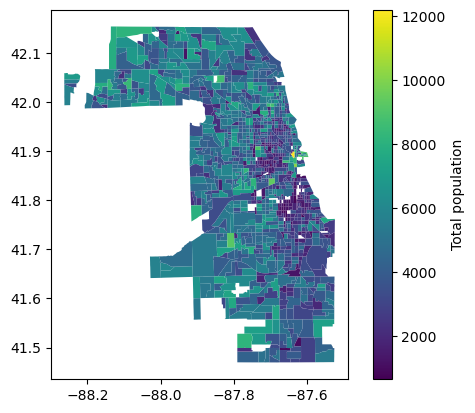

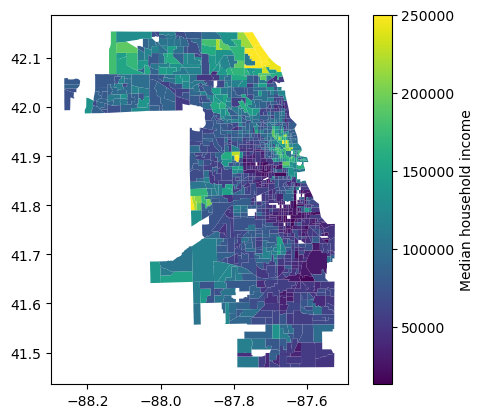

In [71]:
geo_census_data.plot(column='total_population', legend=True,
                     legend_kwds={"label": "Total population"})
geo_census_data.plot(column='median_household_income', legend=True,
                     legend_kwds={"label": "Median household income"})

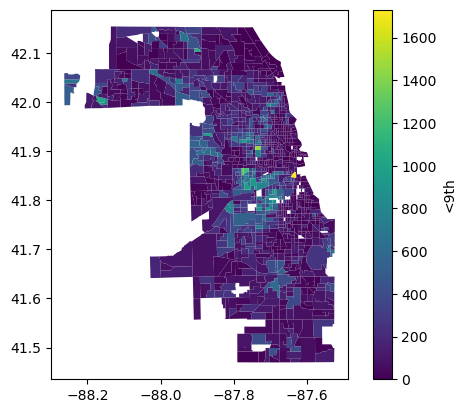

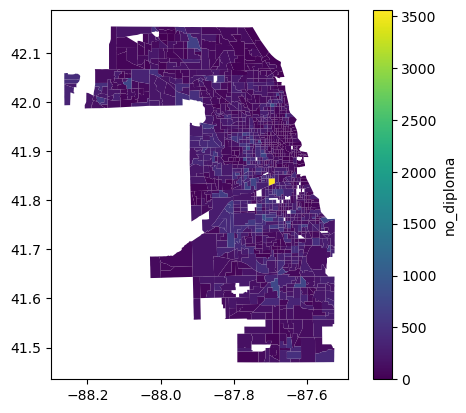

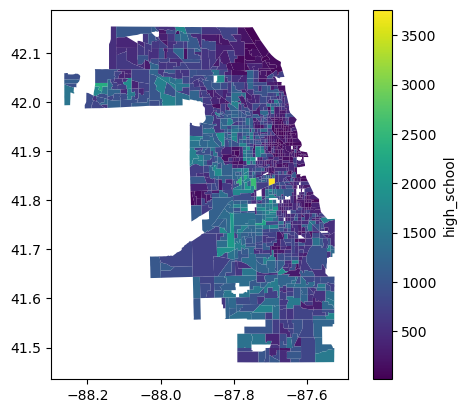

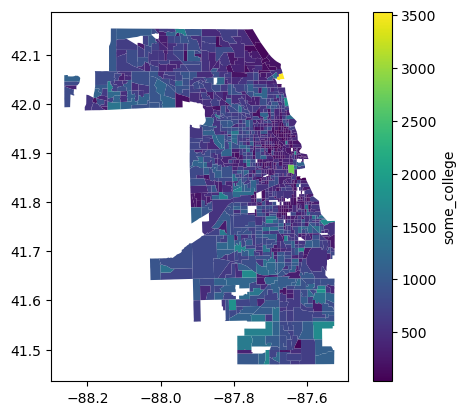

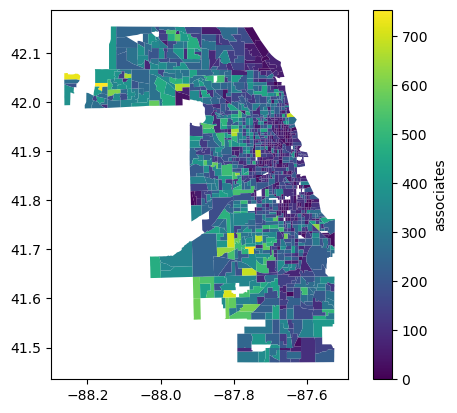

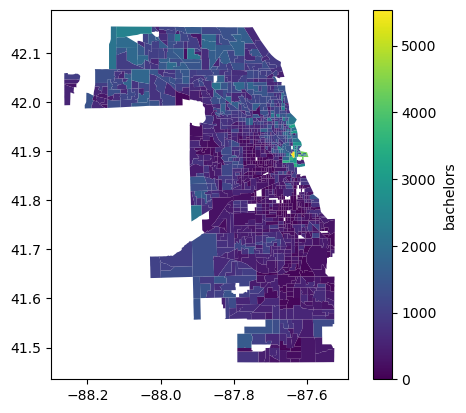

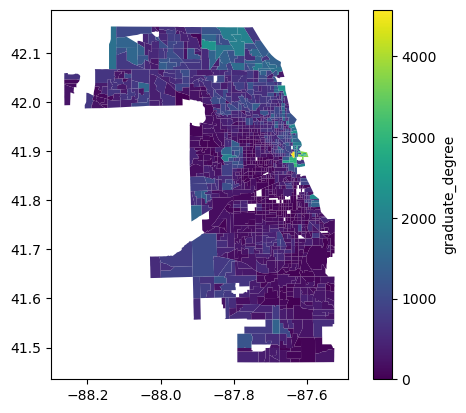

In [72]:
for label in ['<9th', 'no_diploma', 'high_school', 'some_college', 'associates', 'bachelors', 'graduate_degree']:
    geo_census_data.plot(column=label, legend=True,
                        legend_kwds={"label": label})

Notice that there is a single census tract where more than 1000 people have only some high school (`no_diploma`). This is tract 8435, and it is the location of the Cook County Department of Corrections. According to https://www.cookcountyil.gov/service/department-corrections,

> The Cook County Department of Corrections (CCDOC) is one of the largest single site county pre-detention facilities in the United States. Primarily holding pre-trial detainees, the Department admits approximately roughly 100,000 detainees annually and averages a daily population of 9,000. The facility covers more than eight city blocks with ten divisions, a health services facility, two education departments, a privatized food service and commissary agency, and four additional onsite Sheriff’s departments.

**Question!** Do inmates at CCDOC count as residents of this tract?

In [73]:
census_data.loc[census_data['no_diploma'] > 1000]

,name,total_population,median_household_income,white_alone,black_alone,indigenous_alone,asian_alone,pacific_islander_alone,other_alone,multiracial,...,in_labor_force_20_64,not_in_labor_force_20_64,unemployed_20_64,<9th,no_diploma,high_school,some_college,associates,bachelors,graduate_degree
1322,Census Tract 8435; Cook County; Illinois,9398.0,52875.0,2352.0,6060.0,0.0,81.0,0.0,341.0,564.0,...,446.0,8174.0,36.0,490.0,3562.0,3759.0,860.0,265.0,203.0,8.0
